In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [ ]:
# 1. Data Loading and Initial Inspection

In [9]:
df = pd.read_excel("EastWestAirlines.xlsx", sheet_name = 'data')
df.head()

,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,1,28143,0,1,1,1,174,1,0,0,7000,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   ID#                3999 non-null   int64
 1   Balance            3999 non-null   int64
 2   Qual_miles         3999 non-null   int64
 3   cc1_miles          3999 non-null   int64
 4   cc2_miles          3999 non-null   int64
 5   cc3_miles          3999 non-null   int64
 6   Bonus_miles        3999 non-null   int64
 7   Bonus_trans        3999 non-null   int64
 8   Flight_miles_12mo  3999 non-null   int64
 9   Flight_trans_12    3999 non-null   int64
 10  Days_since_enroll  3999 non-null   int64
 11  Award?             3999 non-null   int64
dtypes: int64(12)
memory usage: 375.0 KB


In [15]:
df.describe()


,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
count,3999.000000,3.999000e+03,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.00000,3999.000000,3999.000000,3999.00000,3999.000000
mean,2014.819455,7.360133e+04,144.114529,2.059515,1.014504,1.012253,17144.846212,11.60190,460.055764,1.373593,4118.55939,0.370343
std,1160.764358,1.007757e+05,773.663804,1.376919,0.147650,0.195241,24150.967826,9.60381,1400.209171,3.793172,2065.13454,0.482957
min,1.000000,0.000000e+00,0.000000,1.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,2.00000,0.000000
25%,1010.500000,1.852750e+04,0.000000,1.000000,1.000000,1.000000,1250.000000,3.00000,0.000000,0.000000,2330.00000,0.000000
50%,2016.000000,4.309700e+04,0.000000,1.000000,1.000000,1.000000,7171.000000,12.00000,0.000000,0.000000,4096.00000,0.000000
75%,3020.500000,9.240400e+04,0.000000,3.000000,1.000000,1.000000,23800.500000,17.00000,311.000000,1.000000,5790.50000,1.000000
max,4021.000000,1.704838e+06,11148.000000,5.000000,3.000000,5.000000,263685.000000,86.00000,30817.000000,53.000000,8296.00000,1.000000


In [16]:
# 2. Data Preprocessing

In [17]:
# a. Missing Values Check
print("\nMissing Values per Column:")
print(df.isnull().sum())


Missing Values per Column:
ID#                  0
Balance              0
Qual_miles           0
cc1_miles            0
cc2_miles            0
cc3_miles            0
Bonus_miles          0
Bonus_trans          0
Flight_miles_12mo    0
Flight_trans_12      0
Days_since_enroll    0
Award?               0
dtype: int64


In [63]:
# b. Outlier Removal using IQR
print("\nRemoving Outliers using IQR...")
def remove_outliers_iqr(data, columns):
    df_filtered = data.copy()
    for col in columns:
        Q1 = df_filtered[col].quantile(0.25)
        Q3 = df_filtered[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_filtered = df_filtered[(df_filtered[col] >= lower_bound) & (df_filtered[col] <= upper_bound)]
    return df_filtered

numerical_cols = df.drop('ID#', axis=1).columns  # Exclude 'ID#' for outlier removal
df_no_outliers = remove_outliers_iqr(df, numerical_cols)
print(f"Original DataFrame shape: {df.shape}")
print(f"DataFrame shape after outlier removal: {df_no_outliers.shape}")


Removing Outliers using IQR...
Original DataFrame shape: (3999, 12)
DataFrame shape after outlier removal: (1785, 12)


In [101]:
# c. Scaling Features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_no_outliers.drop('ID#', axis=1))  # Exclude 'ID#'



In [23]:
# a. Descriptive Statistics
print("\nDescriptive Statistics:")
print(df_no_outliers.describe())


Descriptive Statistics:
               ID#        Balance  Qual_miles    cc1_miles  cc2_miles  \
count  1785.000000    1785.000000      1785.0  1785.000000     1785.0   
mean   2219.113725   42256.208964         0.0     1.545658        1.0   
std    1172.641448   40136.422130         0.0     0.955433        0.0   
min       1.000000      68.000000         0.0     1.000000        1.0   
25%    1214.000000   12895.000000         0.0     1.000000        1.0   
50%    2322.000000   28464.000000         0.0     1.000000        1.0   
75%    3291.000000   59797.000000         0.0     2.000000        1.0   
max    4021.000000  196922.000000         0.0     4.000000        1.0   

       cc3_miles   Bonus_miles  Bonus_trans  Flight_miles_12mo  \
count     1785.0   1785.000000  1785.000000             1785.0   
mean         1.0   7131.399440     7.684034                0.0   
std          0.0  10483.803374     7.251480                0.0   
min          1.0      0.000000     0.000000          


Histograms of Numerical Features:


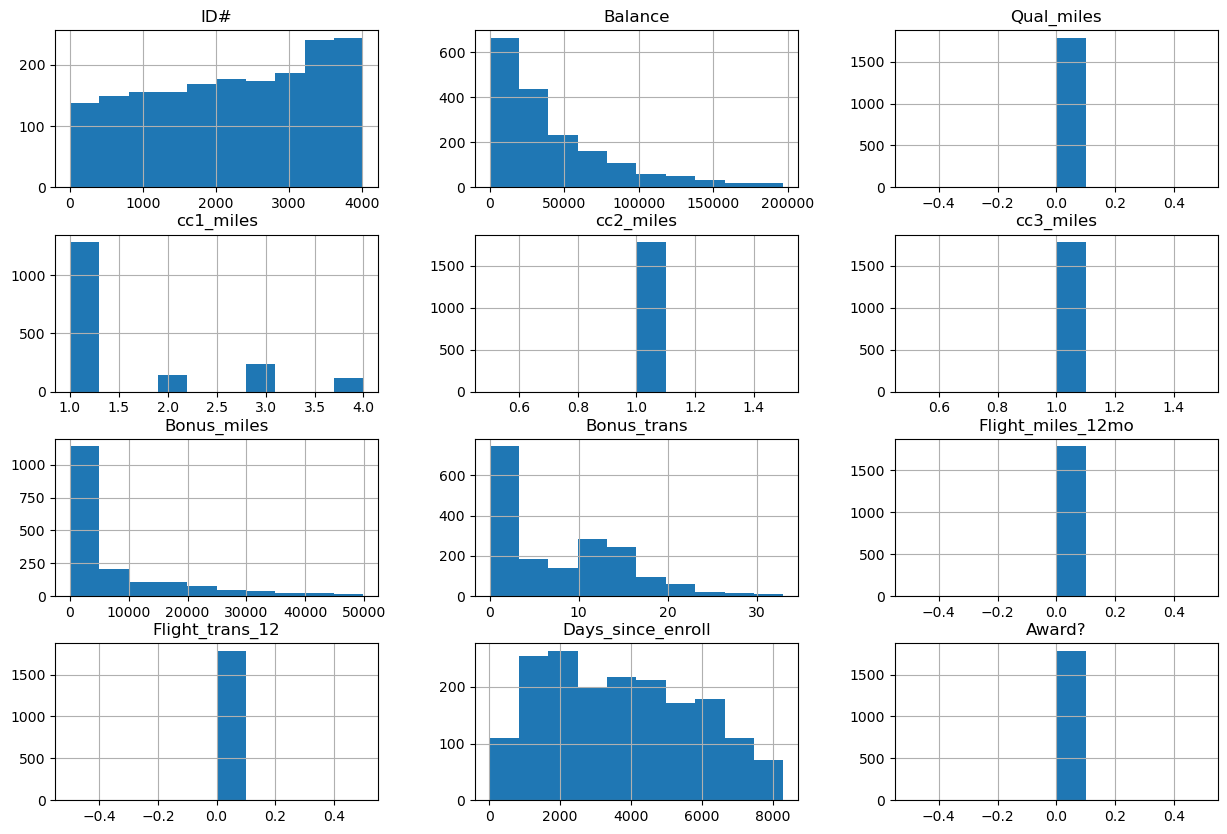

In [24]:
# b. Histograms
print("\nHistograms of Numerical Features:")
df_no_outliers.hist(figsize=(15, 10))
plt.show()


Pair Plots of Numerical Features:


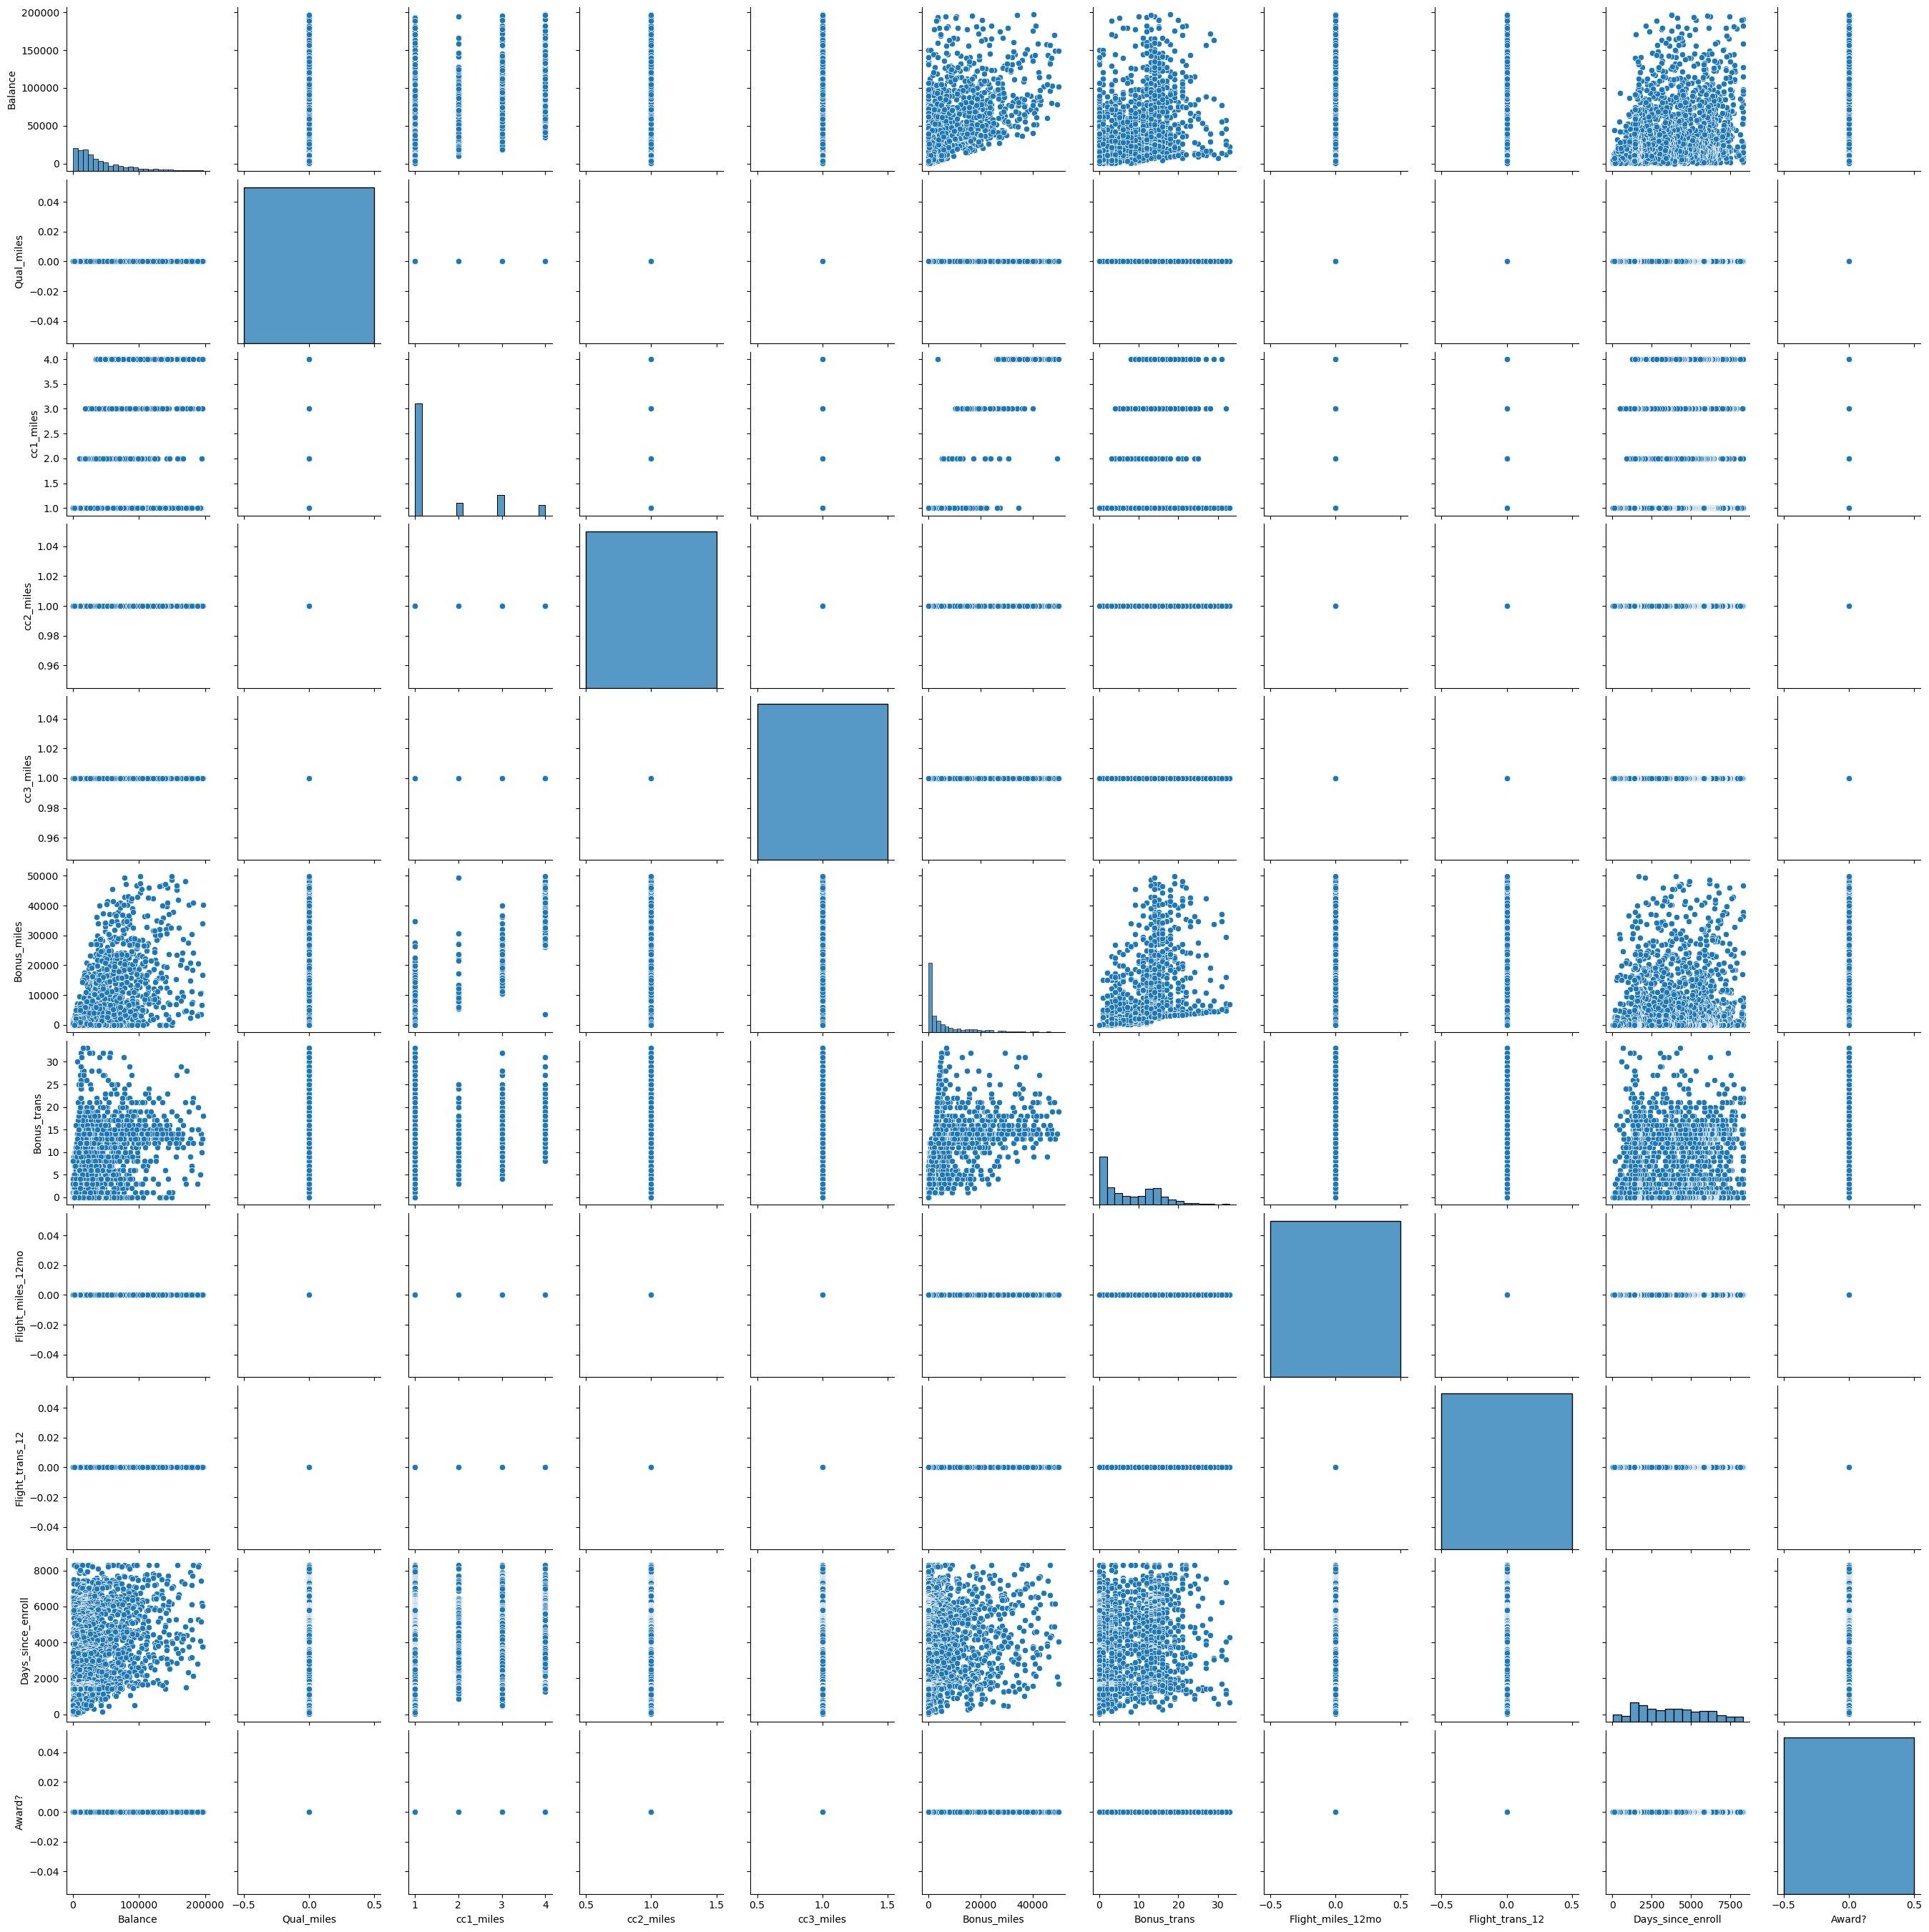

In [25]:
# c. Scatter Plots (Pair Plots)
print("\nPair Plots of Numerical Features:")
sns.pairplot(df_no_outliers.drop('ID#', axis=1))
plt.show()


Correlation Matrix:


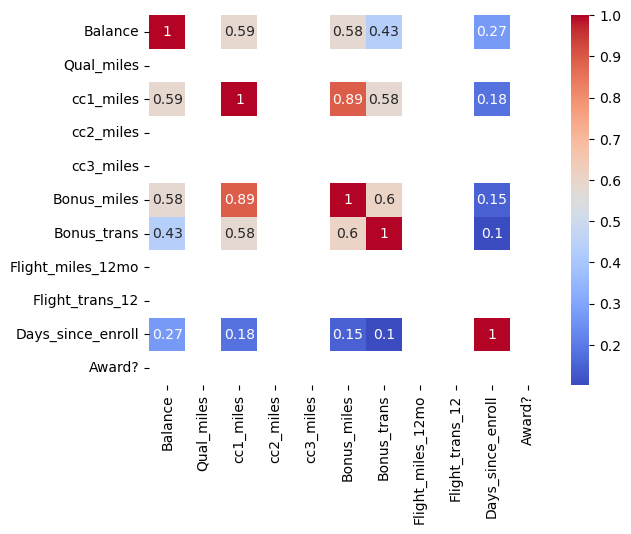

In [26]:
# d. Correlation Matrix
print("\nCorrelation Matrix:")
correlation_matrix = df_no_outliers.drop('ID#', axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [27]:
# 4. Clustering Algorithms


K-Means Clustering...


C:\Users\udits\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
C:\Users\udits\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
C:\Users\udits\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
C:\Users\udits\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

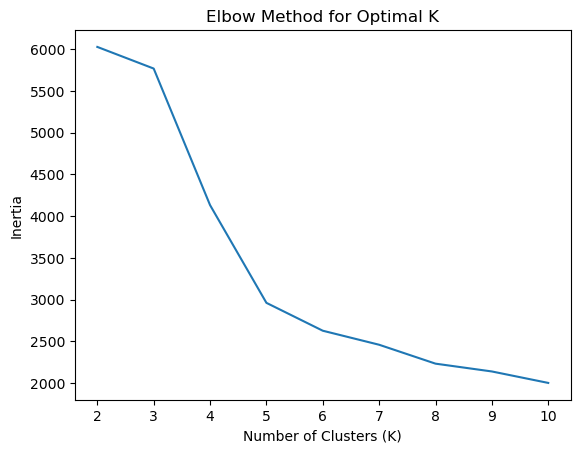

K-Means Silhouette Score: 0.3197031319805198


C:\Users\udits\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


In [50]:
# a. K-Means
print("\nK-Means Clustering...")
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 11), inertia)
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()

optimal_k = 4  # Choose optimal K based on the elbow method.4 is chosen as the optimal number of clusters because it represents a good balance between minimizing inertia (tight clusters) and avoiding an unnecessarily large number of clusters.
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_data)

kmeans_silhouette = silhouette_score(scaled_data, kmeans_labels)
print(f"K-Means Silhouette Score: {kmeans_silhouette}")

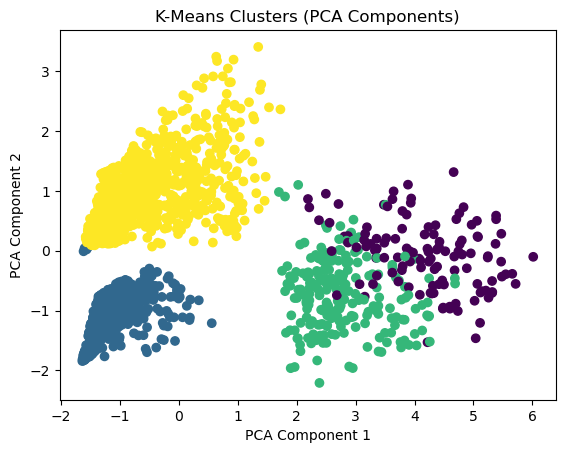

In [53]:
#  Visualize Clusters (Example for K-Means using two features)

pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data)

# Create a DataFrame with the PCA components and cluster labels
pca_df = pd.DataFrame(data=pca_components, columns=['PCA Component 1', 'PCA Component 2'])
pca_df['kmeans_cluster'] = kmeans_labels

# Visualize the clusters using the PCA components
plt.scatter(pca_df['PCA Component 1'], pca_df['PCA Component 2'], c=pca_df['kmeans_cluster'], cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-Means Clusters (PCA Components)')
plt.show()

In [102]:
# Add the cluster labels to the DataFrame
df_no_outliers['kmeans_cluster'] = kmeans_labels

# Calculate the mean values for each cluster
mean_by_cluster = df_no_outliers.groupby('kmeans_cluster').mean()
print("Mean Values by K-Means Cluster:")
print(mean_by_cluster)

print("\n-------------------------------\n")  # Add a separator for readability

# Calculate the median values for each cluster
median_by_cluster = df_no_outliers.groupby('kmeans_cluster').median()
print("Median Values by K-Means Cluster:")
print(median_by_cluster)

Mean Values by K-Means Cluster:
                        ID#        Balance  Qual_miles  cc1_miles  cc2_miles  \
kmeans_cluster                                                                 
0               1181.239669  128899.570248         0.0   3.520661        1.0   
1               3244.342905   19909.929054         0.0   1.008446        1.0   
2               2069.159817   70721.904110         0.0   3.173516        1.0   
3               1693.307151   38166.131301         0.0   1.220399        1.0   

                cc3_miles   Bonus_miles  Bonus_trans  Flight_miles_12mo  \
kmeans_cluster                                                            
0                     1.0  29968.512397    16.223140                0.0   
1                     1.0   1448.464527     2.488176                0.0   
2                     1.0  22290.310502    14.872146                0.0   
3                     1.0   3944.066823     8.233294                0.0   

                Flight_trans_12  Day

K-Means Cluster Analysis (K=4)

1. Visual Analysis (PCA Components):

Four Clusters:
- Cluster 0 (Dark Blue): Bottom-left.
- Cluster 1 (Yellow): Top-left and center.
- Cluster 2 (Teal): Bottom-right and right.
- Cluster 3 (Dark Purple): Right side.
- Separation: Some overlap, especially between Cluster 2 and Cluster 3.

2. Elbow Method and Silhouette Score:

- Optimal K: K = 4.
- Silhouette Score: 0.319703 (Moderate separation).

3. Feature Analysis (Mean Values):

a) Cluster 0 (Dark Blue):

- Very High Balance (128899): Customers with the highest balances.
- High Bonus Miles (29968): High bonus miles.
- High Bonus Trans (16.2): High number of bonus transactions.
- Very Long Days Since Enroll (5640): Longest enrollment length.
- Award = 0: No recent awards.
- Insight: These are the most loyal, high-value customers with very high balances, significant bonus activity, and long-term enrollment.

b)Cluster 1 (Yellow):

- Low Balance (19909): Customers with the lowest balances.
- Very Low Bonus Miles (1448): Very low bonus miles.
- Very Low Bonus Trans (2.4): Very low number of bonus transactions.
- Very Short Days Since Enroll (1879): Shortest enrollment length.
- Award = 0: No recent awards.
- Insight: These are the least engaged, low-value customers with low balances, minimal bonus activity, and relatively recent enrollment.

c) Cluster 2 (Teal):

- Moderate Balance (70721): Customers with moderate balances.
- Moderate Bonus Miles (22290): Moderate bonus miles.
- Moderate Bonus Trans (14.8): Moderate number of bonus transactions.
- Moderate Days Since Enroll (3989): Moderate enrollment length.
- Award = 0: No recent awards.
- Insight: Customers with moderate engagement, moderate balances, and moderate bonus activity.

d) Cluster 3 (Dark Purple):

- Low Balance (38166): Customers with low balances.
- Low Bonus Miles (3944): Low bonus miles.
- Low Bonus Trans (8.2): Low number of bonus transactions.
- Long Days Since Enroll (4667): Long enrollment length.
- Award = 0: No recent awards.
- Insight: Customers with low balances and bonus activity but are loyal and have been enrolled for a long time.


Hierarchical Clustering ...


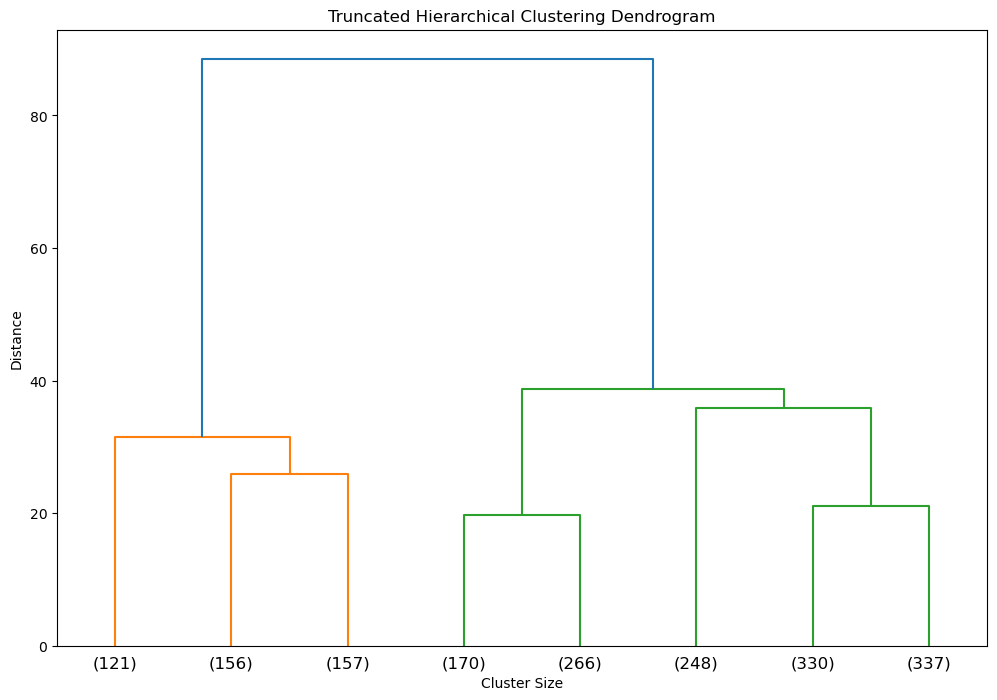

In [38]:
# b. Hierarchical Clustering
print("\nHierarchical Clustering ...")
linkage_matrix = linkage(scaled_data, method='ward')

# Truncate the dendrogram to show the last 'p' merged clusters
p = 8  # Adjust this value as needed

plt.figure(figsize=(12, 8))  # Adjust figure size as needed
dendrogram(linkage_matrix, truncate_mode='lastp', p=p)

plt.xlabel("Cluster Size")  # Or an appropriate label
plt.ylabel("Distance")
plt.title("Truncated Hierarchical Clustering Dendrogram")
plt.show()

Hierarchical Clustering Visualization (PCA Components):


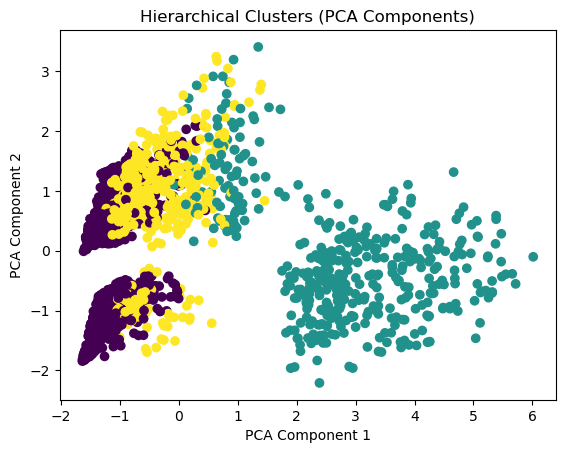

In [57]:
# Hierarchical Clustering Visualization

print("Hierarchical Clustering Visualization (PCA Components):")

# Apply PCA to reduce the data to two components
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data)

# Create a DataFrame with the PCA components and cluster labels
pca_df = pd.DataFrame(data=pca_components, columns=['PCA Component 1', 'PCA Component 2'])
pca_df['hierarchical_cluster'] = hierarchical_labels

# Visualize the clusters using the PCA components
plt.scatter(pca_df['PCA Component 1'], pca_df['PCA Component 2'], c=pca_df['hierarchical_cluster'], cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Hierarchical Clusters (PCA Components)')
plt.show()

In [94]:
# Calculate the mean values for each cluster
# Assign cluster labels using fcluster
cluster_labels = fcluster(linkage_matrix, t=3, criterion='maxclust')  # Adjust t and criterion as needed

# Add the cluster labels to the DataFrame
df_no_outliers['Hierarchical_cluster'] = cluster_labels

# Calculate the mean values for each cluster
mean_by_cluster = df_no_outliers.groupby('Hierarchical_cluster').mean()
print("Mean Values by Hierarchical Cluster:")
print(mean_by_cluster)

print("\n-------------------------------\n")  # Add a separator for readability

# Calculate the median values for each cluster
median_by_cluster = df_no_outliers.groupby('Hierarchical_cluster').median()
print("Median Values by Hierarchical Cluster:")
print(median_by_cluster)

Mean Values by Hierarchical Cluster:
                              ID#       Balance  Qual_miles  cc1_miles  \
Hierarchical_cluster                                                     
1                     1822.661290  90937.301843         0.0   3.016129   
2                     2404.360092  30781.887615         0.0   1.227064   
3                     2318.887432  24633.487432         0.0   1.000000   

                      cc2_miles  cc3_miles   Bonus_miles  Bonus_trans  \
Hierarchical_cluster                                                    
1                           1.0        1.0  21611.758065    14.771889   
2                           1.0        1.0   5726.050459    12.766055   
3                           1.0        1.0    932.772678     1.900546   

                      Flight_miles_12mo  Flight_trans_12  Days_since_enroll  \
Hierarchical_cluster                                                          
1                                   0.0              0.0        4463

Hierarchical  Visualization 

1. Visual Analysis (PCA Components):

Three Clusters:
- Cluster 1 (Yellow): Located in the top-left and the center.
- Cluster 2 (Dark Purple): Located in the bottom-left and the left side.
- Cluster 3 (Teal): Located in the right side.
- Separation: Good separation between the clusters in the PCA component space.

2. Dendrogram Analysis:

Three Clusters: Confirmed by the dendrogram.
- Cluster 1: Smallest, distinct.
- Cluster 2: Larger, more average.
- Cluster 3: Most distinct.

3. Feature Analysis (Mean Values):

a) Cluster 1 (Yellow):

- High Balance (90937): Customers with high balances.
- Moderate Bonus Miles (21611): Moderate bonus miles.
- Moderate Bonus Trans (14.7): Moderate number of bonus transactions.
- Long Days Since Enroll (4463): Long enrollment length.
- Award = 0: No recent awards.
- Insight: Loyal customers with high balances, moderate bonus activity, and long-term enrollment, but no recent awards.

b) Cluster 2 (Dark Purple):

- Low Balance (30781): Customers with low balances.
- Low Bonus Miles (5726): Low bonus miles.
- Moderate Bonus Trans (12.7): Moderate number of bonus transactions.
- Moderate Days Since Enroll (3379): Moderate enrollment length.
- Award = 0: No recent awards.
- Insight: Customers with low balances and bonus miles, moderate bonus activity, and moderate enrollment length. They are less engaged compared to Cluster 1.


c) Cluster 3 (Teal):

- Low Balance (24633): Customers with the lowest balances.
- Very Low Bonus Miles (932): Very low bonus miles.
- Very Low Bonus Trans (1.9): Very low number of bonus transactions.
- Moderate Days Since Enroll (3540): Moderate enrollment length.
- Award = 0: No recent awards.
- Insight: Customers with the lowest balances and bonus activity. They are the least engaged group among the three clusters.

In [90]:
# c. DBSCAN
print("\nDBSCAN Clustering...")
dbscan = DBSCAN(eps=1.5, min_samples=5)  # Tune parameters as needed
dbscan_labels = dbscan.fit_predict(scaled_data)

# Silhouette score for DBSCAN (excluding noise)
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
if len(set(dbscan_labels)) > 1 and -1 in dbscan_labels: # check if there is more than 1 cluster and noise points
    dbscan_silhouette = silhouette_score(scaled_data[core_samples_mask], dbscan_labels[core_samples_mask])
    print(f"DBSCAN Silhouette Score: {dbscan_silhouette}")
else:
    print("DBSCAN did not create more than one cluster, or no noise points were found. Silhouette score not applicable.")



DBSCAN Clustering...
DBSCAN Silhouette Score: 0.5017772215982069



DBSCAN Clustering Visualization:


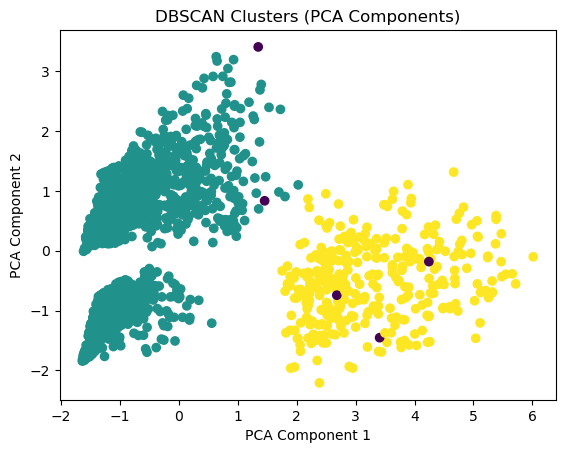

In [88]:
# DBSCAN Visualization
import matplotlib.pyplot as plt
import seaborn as sns

print("\nDBSCAN Clustering Visualization:")

pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data)

# Create a DataFrame with the PCA components and cluster labels
pca_df = pd.DataFrame(data=pca_components, columns=['PCA Component 1', 'PCA Component 2'])
pca_df['dbscan_cluster'] = dbscan_labels

# Visualize the clusters using the PCA components
plt.scatter(pca_df['PCA Component 1'], pca_df['PCA Component 2'], c=pca_df['dbscan_cluster'], cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('DBSCAN Clusters (PCA Components)')
plt.show()

In [81]:
# Calculate the mean values for each cluster
# Add the cluster labels to the DataFrame
df_no_outliers['dbscan_cluster'] = dbscan_labels

mean_by_cluster = df_no_outliers.groupby('dbscan_cluster').mean()
print("Mean Values by DBSCAN Cluster:")
print(mean_by_cluster)

print("\n-------------------------------\n") # Add a separator for readability

# Calculate the median values for each cluster
median_by_cluster = df_no_outliers.groupby('dbscan_cluster').median()
print("Median Values by DBSCAN Cluster:")
print(median_by_cluster)

Mean Values by DBSCAN Cluster:
                        ID#        Balance  Qual_miles  cc1_miles  cc2_miles  \
dbscan_cluster                                                                 
-1              2514.800000  136002.000000         0.0   1.600000        1.0   
 0              2332.844398   30557.543568         0.0   1.137621        1.0   
 1              1722.308383   91500.344311         0.0   3.311377        1.0   

                cc3_miles   Bonus_miles  Bonus_trans  Flight_miles_12mo  \
dbscan_cluster                                                            
-1                    1.0  27570.800000    17.000000                0.0   
 0                    1.0   2928.331950     5.914246                0.0   
 1                    1.0  25021.934132    15.206587                0.0   

                Flight_trans_12  Days_since_enroll  Award?  
dbscan_cluster                                              
-1                          0.0        3446.600000     0.0  
 0       

DBSCAN Visualization 

- Cluster Separation: The visualization shows some separation between the clusters in the PCA component space, but there's also significant overlap.

- Noise Points: There are likely many points that are not assigned to any specific cluster, indicating noise points. These points are scattered throughout the plot.

- Cluster Shapes: The clusters have irregular shapes, which is typical of DBSCAN, as it can find clusters of arbitrary shapes.

Silhouette Score: 0.09770556975098581

- Low Score: The Silhouette Score is very low, indicating that the clusters are not well-separated.
- Interpretation: The low score suggests that the clusters are overlapping, or that there's a lot of noise in the data that DBSCAN couldn't effectively separate.


Cluster Analysis:

1) Cluster -1 (Noise):

- High Balance (136002): Customers with very high balances.
- High Bonus_miles (27570): Customers with high bonus miles.
- Moderate Bonus_trans (17): Moderate number of bonus transactions.
- Low Days_since_enroll (3446): Relatively recent enrollment.
- Award = 0: No recent awards.

- Insight: These are likely high-value customers with a lot of miles and bonuses, but they are relatively new and haven't received recent awards. They are outliers and don't fit well into the main clusters.

2) Cluster 0 (Yellow):

- Low Balance (30557): Customers with low balances.
- Low Bonus_miles (2928): Customers with low bonus miles.
- Low Bonus_trans (5.9): Low number of bonus transactions.
- Moderate Days_since_enroll (3518): Moderate enrollment length.
- Award = 0: No recent awards.

- Insight: These customers are likely less engaged with the frequent flyer program. They have lower balances and bonuses and are not receiving awards.

3) Cluster 1 (Teal):

- Moderate Balance (91500): Customers with moderate balances.
- High Bonus_miles (25021): Customers with high bonus miles.
- High Bonus_trans (15.2): High number of bonus transactions.
- High Days_since_enroll (4625): Long enrollment length.
- Award = 0: No recent awards.

- Insight: These are likely loyal customers who have been enrolled for a long time and have accumulated a lot of bonus miles. They might be using the airline's credit cards or other partner programs.